In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

import scipy.sparse as sp
from scipy.optimize import linear_sum_assignment

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
root = Path('extra/wd/step1')

In [3]:
rgba = Image.open(root/'wd_color.png').convert('RGBA')
rgba = np.asarray(rgba)
rgb = rgba[...,:3]
lbls = np.array(Image.open(root/'regions.png'))
tileimg = np.array(Image.open(root/'tiles.png'))
lbls.shape, rgb.shape, tileimg.shape

((2232, 5988), (2232, 5988, 3), (2232, 5988))

In [4]:
def showx(im, cover=lbls):
    plt.figure(figsize=(20,11))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
    

# def get_highlight(rgb, mask, opacity=0.2):
#     alpha = np.zeros_like(mask).astype(np.uint8)
    
#     img = rgb.astype(np.uint8)
    
#     alpha[mask!=0] = 255
#     alpha[mask==0] = int(255*opacity)
    
#     H,W,C = img.shape
    
#     if C == 4:
#         img[...,-1] = alpha
#     else:
#         img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
#     return img
    
# def highlight(rgb, mask, opacity=0.2, cover=lbls):
#     img = get_highlight(rgb, mask, opacity=opacity)
#     return showx(img, cover=cover)
    
    
    
def get_highlight(mask, _rgb=rgb, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = _rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return img
    
def highlight(mask, _rgb=rgb, opacity=0.2, cover=lbls):
    img = get_highlight(mask, _rgb, opacity=opacity)
    return showx(img, cover=cover)
    

def asign_locs()
    
    
# showx(lbls)

In [5]:
graph = load_yaml(root/'graph.yaml')
len(graph)

743

In [6]:
nodeIDs = {node['ID']:node for node in graph.values()}
regs = {node['name']:node for node in graph.values()}
len(nodeIDs)

743

In [7]:
bgs = load_yaml(root/'bgs.yaml')
bgIDs = {node['ID']:node for node in bgs.values()}
len(bgs)

38

In [8]:
filled = expand_labels(lbls,100)
(filled==0).sum(), filled.max()

(0, 786)

# Unit Locations

In [12]:
umap = np.array(Image.open(root/'wd_unit_locs.png')) == 0
ulbls = label(umap)
uregs = regionprops(ulbls)
uregs.insert(0, None)
# showx(ulbls, cover=None)

In [13]:
ucnt = {idx:Counter(filled[ulbls==idx]) for idx in tqdm(range(1,ulbls.max()+1))}
len(ucnt)

  0%|          | 0/752 [00:00<?, ?it/s]

752

In [15]:
ridx, cidx, vidx = zip(*[(r,c,v) for r, cs in ucnt.items() for c, v in cs.items()])
Us = sp.csr_matrix((vidx, (ridx, cidx))) # sparse csr matrix
Us = Us.todense().base
Us.shape

(753, 782)

In [16]:
us, ns = linear_sum_assignment(Us, maximize=True)
# ns, us = ns[list(ridx)], us[list(ridx)]
us = list(map(str,us.tolist()))
len(ns), len(us)

(753, 753)

In [17]:
ulinks = {u:n for n,u in zip(ns, us) if n in nodeIDs}
len(ulinks), len(nodeIDs)
# [(u,nodeIDs[n]['name']) for u,n in ulinks.items() if 'island' not in nodeIDs[n]]
# [(u,bgIDs[n]['name']) for u, n in blinks.items() if 'island' not in bgIDs[n]]

blinks = {u:n for n,u in zip(ns, us) if n in bgIDs}
unknown = {u:n for n,u in zip(ns, us) if u not in blinks and u not in ulinks and n>0}
len(blinks), len(unknown)

ifixes = [(u, regs[bgIDs[n]['island']]['ID']) for u,n in blinks.items()]
_ifixes = dict(ifixes)
assert len(ifixes) == len(_ifixes), 'some islands disappeared'
ifixes = _ifixes
print(len(ifixes))

print(len(ulinks) + len(ifixes))
links = ulinks.copy()
links.update(ifixes)
len(links)

multis = np.where(Us.sum(0)>100)[0]
multis = {x:tuple(map(str,np.where(Us[:,x])[0].tolist())) for x in multis}
print(len(multis))

sep = {u:n for n, us in multis.items() for u in us}
print(len(sep))
links.update(sep)
missing = [x for x in nodeIDs if x not in links.values()]
len(missing)

33
752
9
18


0

In [22]:
# multis

In [19]:
ulocs = {}
for u,n in links.items():
    node = nodeIDs[n]
    name = node['name']
    if name not in ulocs:
        ulocs[name] = []
    ulocs[name].append(list(uregs[int(u)].centroid))
len(ulocs)

743

# Retreat Locations

In [12]:
umap = np.array(Image.open(root/'wd_unit_locs_retreats.png')) == 0
ulbls = label(umap)
uregs = regionprops(ulbls)
uregs.insert(0, None)
# showx(ulbls, cover=None)

In [13]:
ucnt = {idx:Counter(filled[ulbls==idx]) for idx in tqdm(range(1,ulbls.max()+1))}
len(ucnt)

  0%|          | 0/752 [00:00<?, ?it/s]

752

In [15]:
ridx, cidx, vidx = zip(*[(r,c,v) for r, cs in ucnt.items() for c, v in cs.items()])
Us = sp.csr_matrix((vidx, (ridx, cidx))) # sparse csr matrix
Us = Us.todense().base
Us.shape

(753, 782)

In [16]:
us, ns = linear_sum_assignment(Us, maximize=True)
# ns, us = ns[list(ridx)], us[list(ridx)]
us = list(map(str,us.tolist()))
len(ns), len(us)

(753, 753)

In [17]:
ulinks = {u:n for n,u in zip(ns, us) if n in nodeIDs}
len(ulinks), len(nodeIDs)
# [(u,nodeIDs[n]['name']) for u,n in ulinks.items() if 'island' not in nodeIDs[n]]
# [(u,bgIDs[n]['name']) for u, n in blinks.items() if 'island' not in bgIDs[n]]

blinks = {u:n for n,u in zip(ns, us) if n in bgIDs}
unknown = {u:n for n,u in zip(ns, us) if u not in blinks and u not in ulinks and n>0}
len(blinks), len(unknown)

ifixes = [(u, regs[bgIDs[n]['island']]['ID']) for u,n in blinks.items()]
_ifixes = dict(ifixes)
assert len(ifixes) == len(_ifixes), 'some islands disappeared'
ifixes = _ifixes
print(len(ifixes))

print(len(ulinks) + len(ifixes))
links = ulinks.copy()
links.update(ifixes)
len(links)

multis = np.where(Us.sum(0)>100)[0]
multis = {x:tuple(map(str,np.where(Us[:,x])[0].tolist())) for x in multis}
print(len(multis))

sep = {u:n for n, us in multis.items() for u in us}
print(len(sep))
links.update(sep)
missing = [x for x in nodeIDs if x not in links.values()]
len(missing)

33
752
9
18


0

In [22]:
# multis

In [19]:
rlocs = {}
for u,n in links.items():
    node = nodeIDs[n]
    name = node['name']
    if name not in rlocs:
        rlocs[name] = []
    rlocs[name].append(list(uregs[int(u)].centroid))
len(rlocs)

743

In [20]:
name, idx = None, None

name = 'NPO3'
# idx = 580

if name is not None:
    reg = regs[name]
    idx = reg['ID']
else:
    reg = nodeIDs[idx]
    name = reg['name']
print(reg)

{'ID': 733, 'area': 3428, 'edges': {'fleet': ['KURO', 'COCO', 'SEPA', 'NPEC', 'HAWA', 'MAZA', 'NNWP', 'GTEH', 'LINE', 'LUCA', 'NPO1', 'SEPC', 'NWPA', 'NPO2', 'NPO4', 'MICR', 'MRSH', 'GPAN', 'AOLE', 'SOPA', 'CACO', 'RULL', 'WAKE']}, 'name': 'NPO3', 'ocean': 'NPO', 'tiles': [1301, 1393], 'type': 'sea'}


<IPython.core.display.Javascript object>


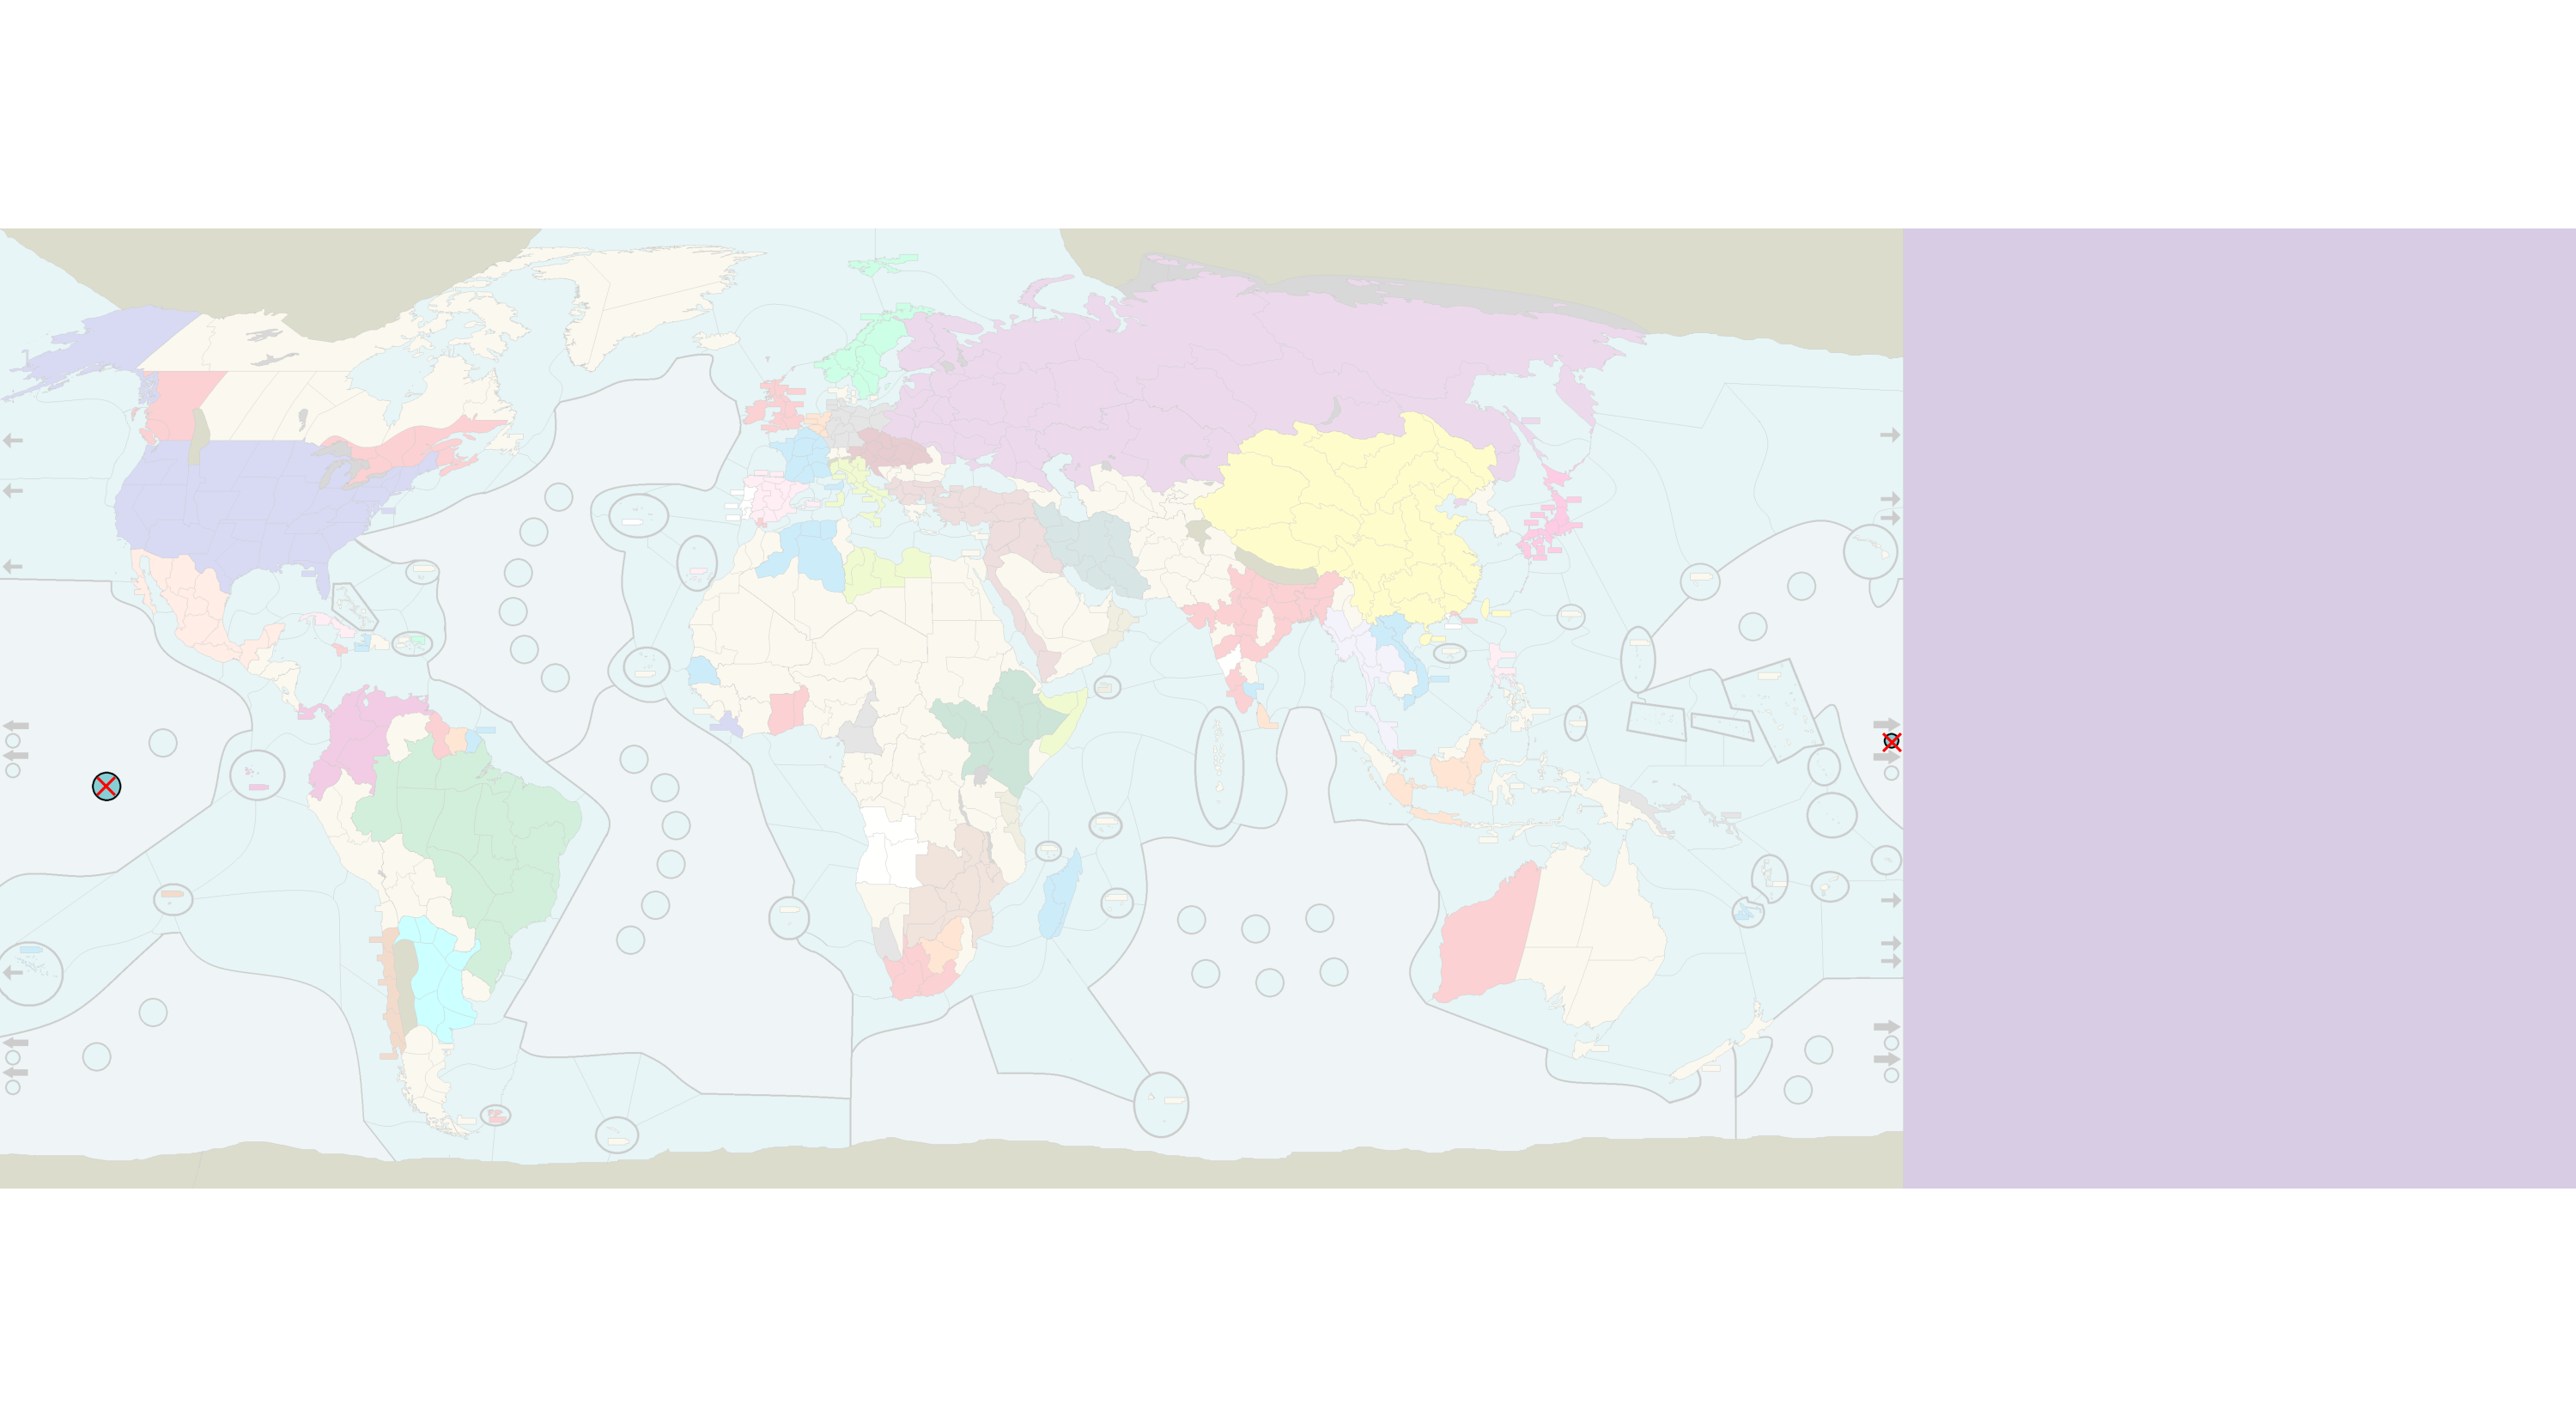

In [21]:
highlight(expand_labels(lbls==idx,5))

plt.scatter(*list(zip(*ulocs[name]))[::-1], s=100, c='r', marker='x');

In [31]:
# highlight(expand_labels(ulbls==11,40))

{'ID': 222, 'area': 464, 'edges': {'fleet': ['BARB', 'AZUR', 'LION', 'VALE']}, 'name': 'BALE', 'tiles': [682, 704, 707], 'type': 'coast', 'water': 'BALE-water'}


NameError: name 'idx' is not defined

In [33]:
mvals = [x for xs in multis.values() for x in xs]
len(mvals)

18

In [30]:
multis

{7: (7, 33),
 726: (336, 531),
 728: (398, 559),
 731: (536, 563),
 733: (534, 574),
 745: (714, 737),
 746: (729, 732),
 747: (726, 731),
 748: (740, 742)}

<IPython.core.display.Javascript object>


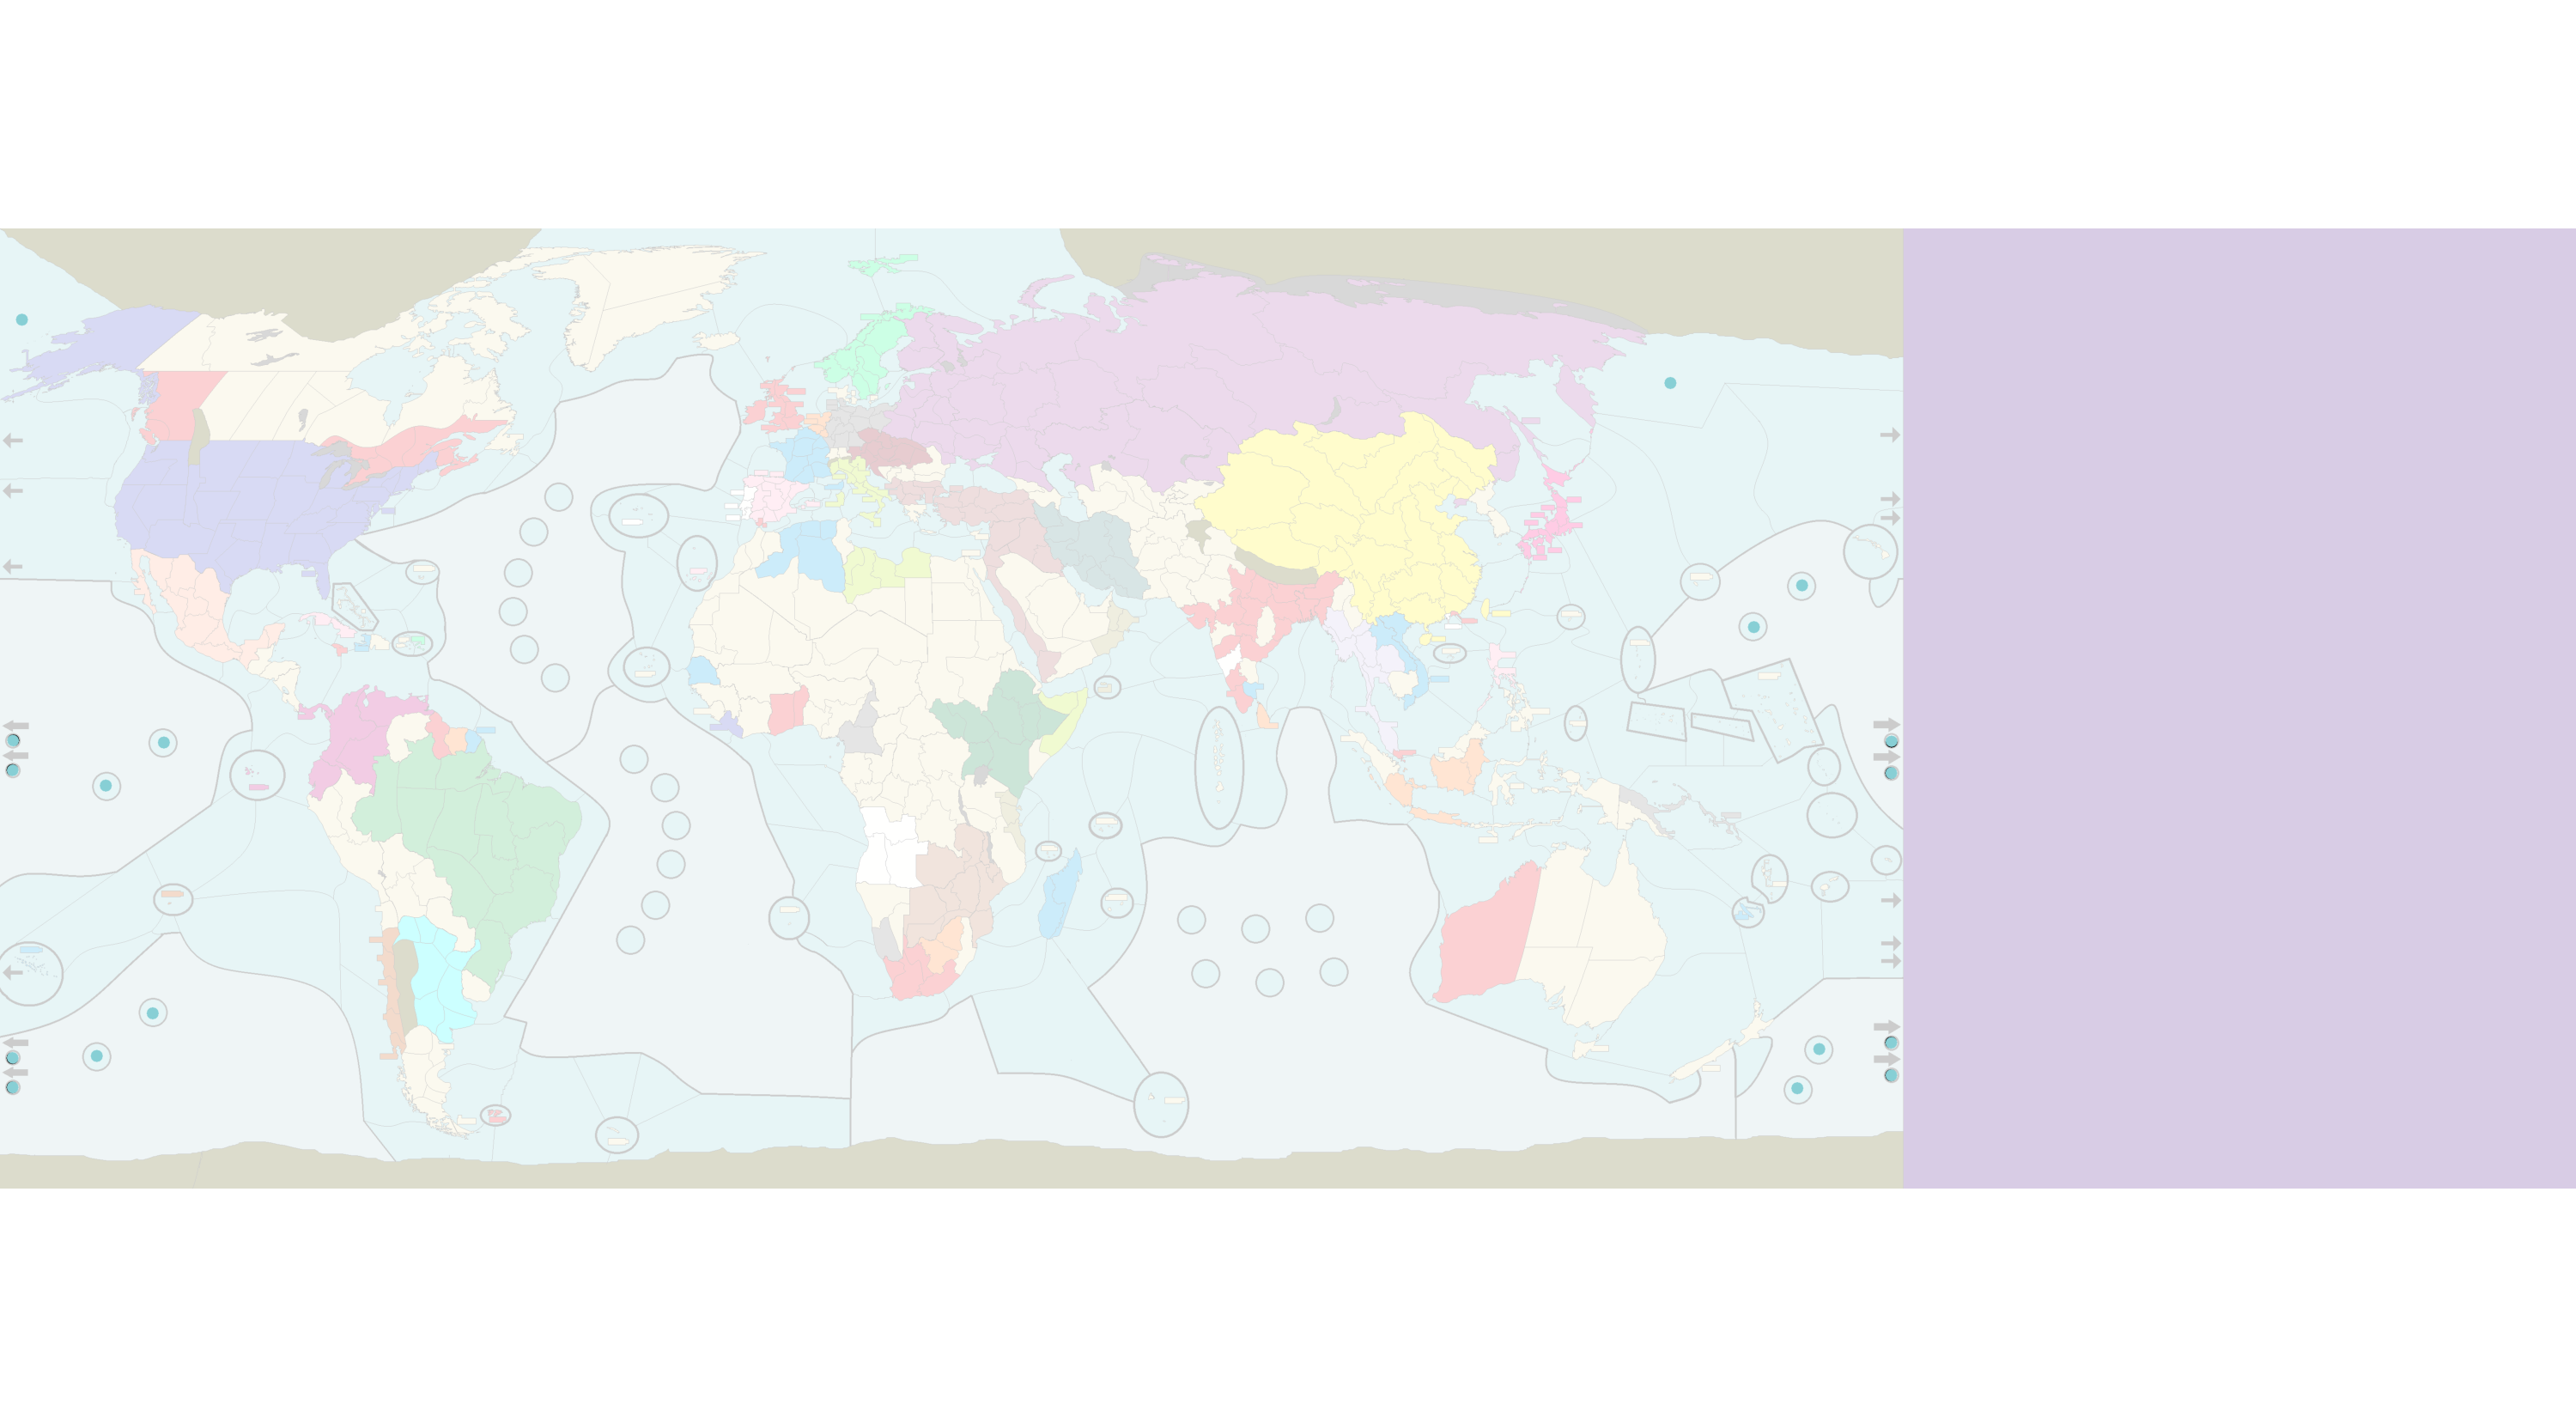

In [43]:
highlight(expand_labels(sum(ulbls==i for i in mvals),10))

In [40]:
wts = {(x,y):Us[y,x] for x,y in warnings.items()}
wts

NameError: name 'warnings' is not defined